In [697]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("ggplot")
%matplotlib inline

import string
import unicodedata

import json
import nltk
from collections import Counter

from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.util import ngrams
from nltk import pos_tag
from nltk import RegexpParser

from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, roc_curve, auc

In [623]:
! ls

README.md             mymodels.py           spark capstone2.ipynb
__pycache__           notfunny.csv          unused.py
funny.csv             reviews.ipynb         yelp_dataset
funnyhist.png         roc_curve.py


## Load and convert data ##

In [491]:
# read in Yelp Reviews
  
data = [json.loads(line) for line in open('yelp_dataset/yelp_academic_dataset_review.json', 'r')]

In [493]:
reviews_df = pd.DataFrame(data)

In [494]:
reviews_df.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,lWC-xP3rd6obsecCYsGZRg,ak0TdVmGKo4pwqdJSTLwWw,buF9druCkbuXLX526sGELQ,4.0,3,1,1,Apparently Prides Osteria had a rough summer a...,2014-10-11 03:34:02
1,8bFej1QE5LXp4O05qjGqXA,YoVfDbnISlW0f7abNQACIg,RA4V8pr014UyUbDvI-LW2A,4.0,1,0,0,This store is pretty good. Not as great as Wal...,2015-07-03 20:38:25
2,NDhkzczKjLshODbqDoNLSg,eC5evKn1TWDyHCyQAwguUw,_sS2LBIGNT5NQb6PD1Vtjw,5.0,0,0,0,I called WVM on the recommendation of a couple...,2013-05-28 20:38:06
3,T5fAqjjFooT4V0OeZyuk1w,SFQ1jcnGguO0LYWnbbftAA,0AzLzHfOJgL7ROwhdww2ew,2.0,1,1,1,I've stayed at many Marriott and Renaissance M...,2010-01-08 02:29:15
4,sjm_uUcQVxab_EeLCqsYLg,0kA0PAJ8QFMeveQWHFqz2A,8zehGz9jnxPqXtOc7KaJxA,4.0,0,0,0,The food is always great here. The service fro...,2011-07-28 18:05:01


In [495]:
len(reviews_df)

8635403

In [496]:
# get 200k dataframe of balanced funny/not funny reviews

len(reviews_df[reviews_df.funny >= 3])

340864

In [497]:
funny_df = reviews_df[reviews_df.funny >= 3].sample(n=100000, random_state=1)
not_funny_df = reviews_df[reviews_df.funny < 3].sample(n=100000, random_state=1)

In [498]:
# save datasets to csv

funny_df.to_csv('funny.csv')
not_funny_df.to_csv('notfunny.csv')

In [499]:
# read in and concatenate

funny_df = pd.read_csv('funny.csv')
not_funny_df = pd.read_csv('notfunny.csv')

df = pd.concat([funny_df, not_funny_df]).drop_duplicates('review_id')
df.shape

(200000, 10)

In [500]:
df = df.drop(['Unnamed: 0'], axis = 1)

In [501]:
df = df.reset_index(drop=True)

In [502]:
df.text

0         A scavenger hunt was hosted by the Paramount r...
1         The Pretty Kitty has 20 locations throughout t...
2         After a very productive business meeting this ...
3         I called in advance to be sure that they had t...
4         Eastern Standard reminds me of that scene in S...
                                ...                        
199995    Very mediocre korean food but great if you're ...
199996    Horrible, I sat at the drive up ordering thing...
199997    COULDN'T BE HAPPIER!  I just got my second tat...
199998    Pizza that's a commodity. They make a certain ...
199999    Very consistent the best coffee good sandwiche...
Name: text, Length: 200000, dtype: object

In [7]:
df.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,DEECPhn5tNBKbuaOeIcd2w,CwBh8Fmr07jFYBKZ2p6Mqg,iNsMwBxFXcP7QvB3994mgA,5.0,3,4,4,A scavenger hunt was hosted by the Paramount r...,2009-07-31 02:33:55
1,Ja7ZM1i_gYFXmxrkJPEPlA,ncIHRw4Vx3Wh9mZhLZxB7g,dgprzdonZcF7PPt-hkUkag,5.0,15,3,6,The Pretty Kitty has 20 locations throughout t...,2015-08-04 00:01:50
2,9E8ZAppLWtL0oJYRbFmOFQ,mdP18-vCtV9nu8DT2Bk6lA,gYuTx4cB_5UutuWIGusmUQ,5.0,14,6,9,After a very productive business meeting this ...,2018-10-15 13:49:54
3,MHBTWs3E8bKR80SOpcelWw,fV4Y0rKuJaahlNfjCH3vfw,ZM3Y7pPuKu67Q_FOLqGx7A,4.0,1,4,0,I called in advance to be sure that they had t...,2012-08-25 01:39:58
4,EcvcH3hHuzlXqG79nIag0w,ys3M-lvO7wCYkhCbqSVCfA,p8ohzzGvGRCHnJKnyO7exA,4.0,0,4,0,Eastern Standard reminds me of that scene in S...,2014-11-08 23:22:35


In [509]:
max(df.funny)

610

In [512]:
len(df[df.funny != 610])

199999

In [528]:
len(df[df.funny < 3])

100000

In [567]:
# get review with 3 funny votes
df[df.funny == 100].iloc[1].text

'Let\'s say I marry a nice lass. Soon, she\'s showing the bump and nine months later, we\'re in Dave\'s Fresh Pasta and she looks at me and says "It\'s time." I try to keep my cool but I freak out and we rush to the hospital. I\'ve got the video camera (which I think is creepy, but her mom wants all the magic recorded) and my scrubs, she\'s in a gurney on her back flawlessly executing on all the Lamaze training we\'ve gone through. The docs and nurses are hovered around her and she\'s at the point of sweating where her hair is all pasted to her wincing face. And then, everything goes quiet except for one nurse who gasps, "Oh my..."\n\nAnd the doc turns around to show me my baby Dave\'s Cuban Sandwich. Everyone\'s embarassed, she\'s looking at me with the "I\'m so sorry" face, and I\'m in a little shock but you know what? I\'m not mad. With the crusty chewy bread, thick slices of pork loin, ham, fresh pickles, swiss and that amazing chipotle aioli, I know how irresistable it can be.\n\n

In [554]:
df[df.funny == 2].iloc[15].text

'Although there may be plenty of tourists, the large array of shops and restaurants make it a pleasurable place to spend your time here. Not pleasurable if you are driving though because you probably won\'t find parking here. The cobblestone streets are cool, but I got lost here! Thank goodness I had my Iphone, and used the GPS. The square often attracts activists, street dwellers, goth subcultures, street performers, conservatives, tourists you name it! They have it.\n\nA cool thing to do is to check out "The Garage". It\'s a small shopping mall that used to be a parking garage.\n\nI\'m not a fan of the national chains in the square though like Urban Outfitters (See my review and find out why) and corporate banks like Bank of America. I would rather support the small locally-run businesses with unique styles. It\'s one of the reasons why I dislike gentrification.\n\nBecause of high rent, the small, independent mom & pop stores suffer, and it changes the culturally heterogeneous charac

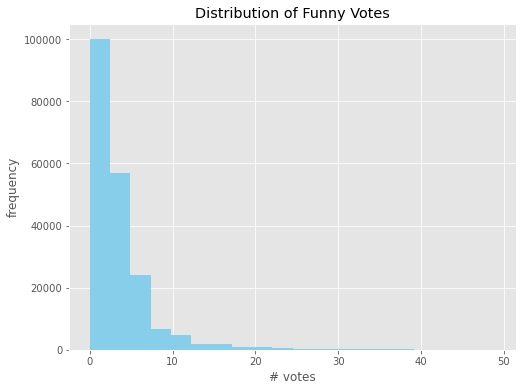

In [562]:
# Histogram of funny column to show class imbalances

fig, ax = plt.subplots(figsize = (8,6))

ax.hist(df[df.funny < 50].funny, bins = 20, color = 'skyblue')
ax.set_title('Distribution of Funny Votes')
ax.set_xlabel('# votes')
ax.set_ylabel('frequency')
plt.savefig('funnyhist.png')

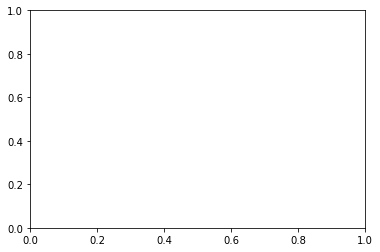

In [55]:
# Barchart of funny vs not funny

fig, ax = plt.subplots()


In [41]:
max(df.funny)

610

In [30]:
(reviews[0]['text'])

"I loved everything about this place. I've only been once but I keep meaning to go back as it was so great (just a bit out of my way). \n\nI went with a fairly large group so we'd all ordered something different (back when it was $6 for everything, it looks like they've changed that now). At the time I got the chickpea fries, which were delicious but watch out for the fiber because I had to sit out of an entire board game. The board game selection was great, and I love that they serve mead (though I didn't get any at 12 pm haha).  The molten lava chocolate cake was so, so good. Seriously.\n\nThe real topping to the experience (other than the great service and the fact that they put lemons in their complimentary ice water) was that they were playing Siouxsie and the Banshees in the background! That + board games + good food + mead = I'm a fan forever."

## Text Processing Pipeline ##

In [9]:
# create new df of just text and label

new_df = pd.concat([df.text, df.funny], axis=1)


In [10]:
new_df['funny or not'] = (new_df.funny >= 3).astype(int)


In [11]:
new_df = new_df.drop(columns ='funny')


In [696]:
new_df.head()


,text,funny or not
0,A scavenger hunt was hosted by the Paramount r...,1
1,The Pretty Kitty has 20 locations throughout t...,1
2,After a very productive business meeting this ...,1
3,I called in advance to be sure that they had t...,1
4,Eastern Standard reminds me of that scene in S...,1


In [15]:
# create toy df for faster processing


In [48]:
toy_funny = funny_df.sample(n=10000, random_state=1)
toy_notfunny = not_funny_df.sample(n=10000, random_state=1)

toy_df = pd.concat([toy_funny, toy_notfunny]).drop_duplicates('review_id')
toy_df = toy_df.drop(['Unnamed: 0'], axis = 1)


In [51]:
toy_df.funny

43660     4
87278     3
14317     3
81932     3
95321    21
         ..
59828     0
47957     0
42429     0
76505     0
49578     0
Name: funny, Length: 20000, dtype: int64

In [52]:
toy = pd.concat([toy_df.text, toy_df.funny], axis=1)

toy['funny or not'] = (toy.funny >= 3).astype(int)
toy = toy.drop(columns ='funny')


In [ ]:
# gensim library for word vectors - come back if time


In [254]:
# Tokenization (don't filter stopwords or punctuation as these may contribute to humor)

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

#tokens = review_text.map(word_tokenize)

#tokenized = [word_tokenize(review_text.lower()) for review in review_text]

# lowercase and tokenize
toy_df['tokens'] = toy_df['text'].str.lower().map(word_tokenize)


In [175]:
type(toy_df)


pandas.core.frame.DataFrame

In [676]:
# stemming/lemmatization

from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer

porter = PorterStemmer()
snowball = SnowballStemmer('english')
wordnet = WordNetLemmatizer()

# docs_porter = [[porter.stem(word) for word in words]
#                for doc in toy_tokens]
# docs_snowball = [[snowball.stem(word) for word in words]
#                  for doc in toy_tokens]
# docs_wordnet = [[wordnet.lemmatize(word) for word in words]
#                 for doc in toy_tokens]

# tokens_porter = [list(map(porter.stem, doc)) for doc in toy_df['tokens']]

# tokens_snowball = [list(map(snowball.stem, doc)) for doc in toy_df['tokens']]

# tokens_wordnet = [list(map(wordnet.lemmatize, doc)) for doc in toy_df['tokens']]


In [191]:
# stem/lemmatize within dataframe

type(tokens_porter)


list

In [194]:
len(tokens_wordnet[0])


186

In [195]:
## Print the stemmed and lemmatized words from the first review for each method
print("%16s %16s %16s %16s" % ("word", "porter", "snowball", "lemmatizer"))

for i in range(min(len(tokens_porter[0]), len(tokens_snowball[0]), len(tokens_wordnet[0]))):
    p, s, w = tokens_porter[0][i], tokens_snowball[0][i], tokens_wordnet[0][i]
    if len(set((p, s, w))) != 1:
        print("%16s %16s %16s %16s" % (toy_df['tokens'][0][i], p, s, w))


            word           porter         snowball       lemmatizer
       scavenger          scaveng          scaveng        scavenger
             was               wa              was               wa
          hosted             host             host           hosted
        recently           recent           recent         recently
            plus              plu             plus             plus
         running              run              run          running
             was               wa              was               wa
         totally            total            total          totally
        watching            watch            watch         watching
      afterwards        afterward        afterward       afterwards
          lovely             love             love           lovely
         sitting              sit              sit          sitting
        charming            charm            charm         charming
        marveled           marvel           marv

In [673]:
# bag of words, max features 3000
# TF-IDF
# will go with lemmatizer to preserve as much of the original word as possible

from sklearn.feature_extraction.text import TfidfVectorizer

def remove_accents(input_str):
    nfkd_form = unicodedata.normalize('NFKD', input_str)
    only_ascii = nfkd_form.encode('ASCII', 'ignore')
    return only_ascii.decode()

def tokenize(doc):
    '''
    INPUT: string
    OUTPUT: list of strings

    Remove accents, tokenize, and lemmatize the document.
    '''
    doc = remove_accents(doc)
    return [wordnet.lemmatize(word) for word in word_tokenize(doc)]


#tfidfvect = TfidfVectorizer(tokenizer=tokenize)

# features
#tfidf_vectorized = tfidfvect.fit_transform(toy_df.text)



In [ ]:
# latent semantic analysis - capstone 3


## TF-IDF Vectorization / EDA ##

In [22]:
# baseline models on top of bag-of-words

# split into train and test sets

X_train, X_test, y_train, y_test = train_test_split(new_df['text'], new_df['funny or not'], test_size=0.2)


In [679]:
# vectorize train data/transform test data

tfidfvect = TfidfVectorizer(max_features = 3000, 
                            sublinear_tf=True, 
                            min_df=5, norm='l2', 
                            encoding='latin-1', 
                            ngram_range=(1, 3))

X_train_tfidf = tfidfvect.fit_transform(X_train)
X_test_tfidf = tfidfvect.transform(X_test)

# get vocab
words = tfidfvect.get_feature_names()

# try max features 3000, 10000 etc. to see if improving
# n-grams: 1, 2, 3
# stopwords 
# stemming, lemma etc.

In [680]:
X_train_tfidf.shape, X_test_tfidf.shape


((160000, 3000), (40000, 3000))

In [681]:
vocab_dict = tfidfvect.vocabulary_
vocab_dict

{'the': 2265,
 'brown': 374,
 'lounge': 1386,
 'is': 1188,
 'located': 1360,
 'just': 1279,
 'outside': 1723,
 'of': 1601,
 'and': 88,
 'offers': 1632,
 'smaller': 2084,
 'compared': 528,
 'to': 2505,
 'that': 2237,
 'larger': 1313,
 'restaurant': 1924,
 'my': 1509,
 'wife': 2879,
 'usually': 2667,
 'eat': 700,
 'here': 1070,
 'because': 308,
 'we': 2781,
 'overpriced': 1731,
 'hot': 1102,
 'dogs': 646,
 'are': 198,
 'offered': 1631,
 'everywhere': 749,
 'else': 708,
 'in': 1142,
 'park': 1744,
 'food': 829,
 'actually': 36,
 'really': 1896,
 'good': 966,
 'seating': 1995,
 'perfect': 1773,
 'for': 838,
 'star': 2148,
 'show': 2054,
 'they': 2431,
 'onto': 1676,
 'chinese': 480,
 'theater': 2407,
 'yes': 2957,
 'bit': 343,
 'pricey': 1850,
 'but': 388,
 'what': 2843,
 'did': 612,
 'you': 2960,
 'expect': 756,
 'from': 891,
 'disney': 634,
 'it': 1222,
 'definitely': 600,
 'better': 334,
 'than': 2232,
 'lot': 1381,
 'other': 1699,
 'around': 213,
 'get': 917,
 'great': 981,
 'see': 200

In [682]:
from collections import Counter
dict(Counter(vocab_dict).most_common(50))

{'zero': 2999,
 'yummy': 2998,
 'yum': 2997,
 'yourself': 2996,
 'your own': 2995,
 'your food': 2994,
 'your': 2993,
 'young': 2992,
 'you would': 2991,
 'you won': 2990,
 'you will': 2989,
 'you want to': 2988,
 'you want': 2987,
 'you ve': 2986,
 'you to': 2985,
 'you the': 2984,
 'you should': 2983,
 'you re looking': 2982,
 'you re in': 2981,
 'you re': 2980,
 'you need to': 2979,
 'you need': 2978,
 'you might': 2977,
 'you may': 2976,
 'you ll': 2975,
 'you like': 2974,
 'you know': 2973,
 'you just': 2972,
 'you have to': 2971,
 'you have': 2970,
 'you go': 2969,
 'you get': 2968,
 'you don': 2967,
 'you do': 2966,
 'you could': 2965,
 'you can get': 2964,
 'you can': 2963,
 'you are': 2962,
 'you and': 2961,
 'you': 2960,
 'yet': 2959,
 'yesterday': 2958,
 'yes': 2957,
 'yelp': 2956,
 'years and': 2955,
 'years ago': 2954,
 'years': 2953,
 'year old': 2952,
 'year': 2951,
 'yeah': 2950}

In [ ]:
# plot most common words

data = dict(Counter(vocab_dict).most_common(50))
pd.DataFrame.from_dict(data)


## Modeling ##

In [637]:
## modeling from py file
import sys, importlib
importlib.reload(sys.modules['mymodels'])
from mymodels import *


In [638]:
# logistic regression

y_pred_lr, y_proba_lr = log_reg_model(X_train_tfidf, X_test_tfidf, y_train)



In [639]:
# naive bayes

y_pred_nb, y_proba_nb = naive_bayes_model(X_train_tfidf, X_test_tfidf, y_train)

In [648]:
# random forest

y_pred_rf, y_proba_rf = random_forest_model(X_train_tfidf, X_test_tfidf, y_train)

In [653]:
# gradient boosting
# ran for > 1hr

y_pred_gbc, y_proba_gbc = gradient_boosting_model(X_train_tfidf, X_test_tfidf, y_train)

In [654]:
# calculate scores

accuracy_scores = []
precision_scores = []
recall_scores = []

y_preds = [y_pred_lr, y_pred_nb, y_pred_rf, y_pred_gbc]

for y_pred in y_preds:
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_scores.append(accuracy)
    
    precision = precision_score(y_test, y_pred)
    precision_scores.append(precision)
    
    recall = recall_score(y_test, y_pred)
    recall_scores.append(recall)
    
# print("Accuracy:", accuracy_score(y_test, y_pred_lr_test))
# print("Precision:", precision_score(y_test, y_pred_lr_test))
# print("Recall:", recall_score(y_test, y_pred_lr_test))


In [655]:
accuracy_scores

[0.75895, 0.722275, 0.707, 0.7457]

In [656]:
precision_scores

[0.761493522987046, 0.7081486371781571, 0.7138173302107729, 0.748992809424244]

In [657]:
recall_scores

[0.7518683854140543, 0.753222651351758, 0.6879670963535136, 0.7366705121131565]

In [683]:
def plot_ROC(ax, fpr, tpr):
    ax.plot([1]+list(fpr), [1]+list(tpr), label="ROC")
    ax.plot([0,1],[0,1], 'k', label="random")
    ax.set_xlabel('fpr')
    ax.set_xlabel('fpr')
    ax.set_ylabel('tpr')
    ax.set_title('ROC Curve')
    ax.legend()

0.8378488873055842
0.7962700897399655
0.7751337275144112
0.8266901765832771


<ipython-input-667-fb5df8d00f95>:26: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('roccurves.png', bbox='tight')


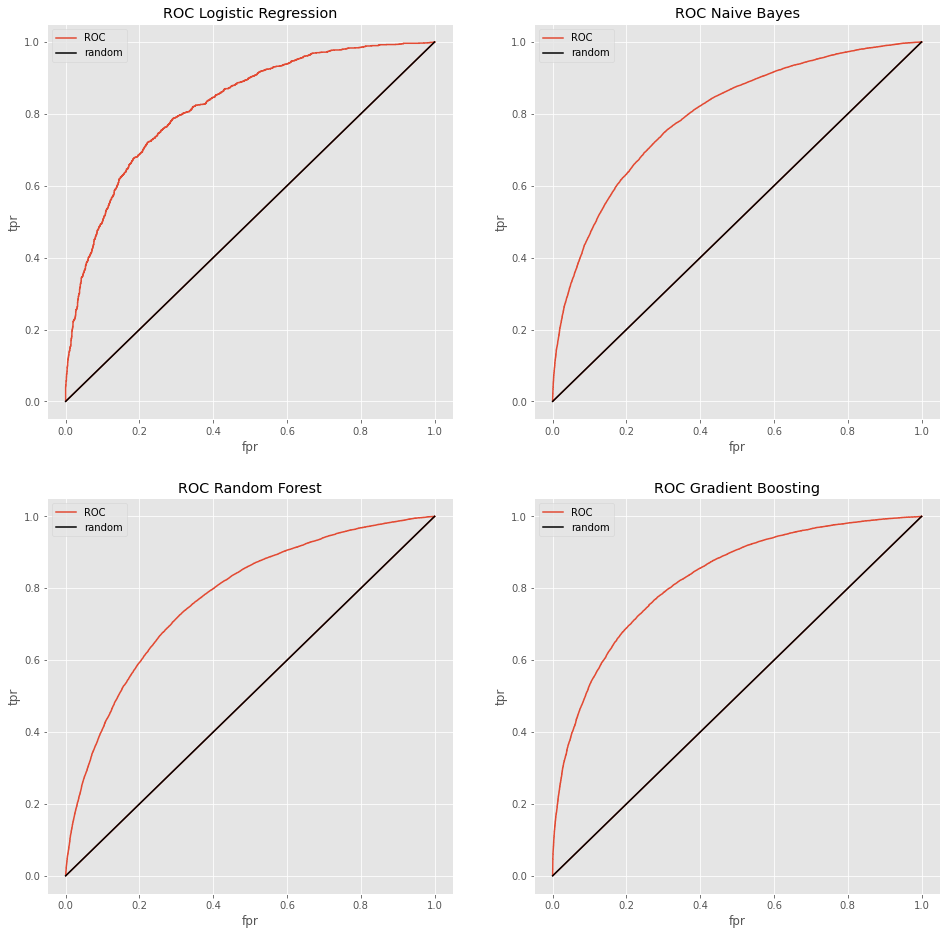

In [667]:
# calculate AUC

# ROC curves
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2,2, figsize = (16,16))

fpr0, tpr0, threshold0 = roc_curve(y_test, y_proba_lr)
plot_ROC(ax0, fpr, tpr)
ax0.title.set_text('ROC Logistic Regression')
print(auc(fpr0, tpr0))

fpr1, tpr1, threshold1 = roc_curve(y_test, y_proba_nb)
plot_ROC(ax1, fpr1, tpr1)
ax1.title.set_text('ROC Naive Bayes')
print(auc(fpr1, tpr1))

fpr2, tpr2, threshold2 = roc_curve(y_test, y_proba_rf)
plot_ROC(ax2, fpr2, tpr2)
ax2.title.set_text('ROC Random Forest')
print(auc(fpr2, tpr2))

fpr3, tpr3, threshold3 = roc_curve(y_test, y_proba_gbc)
plot_ROC(ax3, fpr3, tpr3)
ax3.title.set_text('ROC Gradient Boosting')
print(auc(fpr3, tpr3))

plt.savefig('roccurves.png', bbox='tight')

### Logistic Regression ###

In [387]:
# Cross validation
print(cross_val_score(lr, X_train_tfidf, y_train, cv=5))


[0.76      0.7509375 0.751875  0.751875  0.7559375]


In [694]:
# confusion matrix

confusion_matrix(y_test, y_pred_lr)
# true positive, false negative
# false positive, true negative

array([[15368,  4695],
       [ 4947, 14990]])

In [423]:
lr = LogisticRegression(random_state=0, max_iter = 500)
lr.fit(X_train_tfidf, y_train)


LogisticRegression(max_iter=500, random_state=0)

In [424]:
y_pred_lr_test = lr.predict(X_test_tfidf)
y_proba_lr_test = lr.predict_proba(X_test_tfidf)[:,1]


In [452]:
print("Accuracy:", accuracy_score(y_test, y_pred_lr_test))
print("Precision:", precision_score(y_test, y_pred_lr_test))
print("Recall:", recall_score(y_test, y_pred_lr_test))

Accuracy: 0.758575
Precision: 0.7613382143583486
Recall: 0.7510658574509705


0.8379697085044326


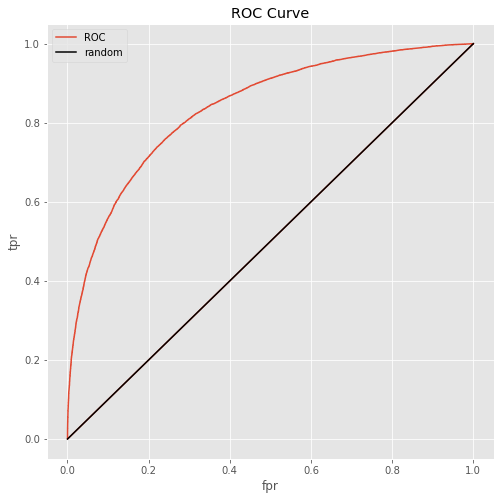

In [684]:
fig, ax = plt.subplots(figsize = (8,8))

fpr, tpr, threshold = roc_curve(y_test, y_proba_lr_test)
plot_ROC(ax, fpr, tpr)
print(auc(fpr, tpr))

In [577]:
lr.coef_[0]


array([ 0.84734555, -0.06424313,  0.16434035, ..., -0.35452723,
       -0.58568149,  0.89402857])

## Feature Importance ##

In [686]:
# words indices
# logistic regression

important_tokens = pd.DataFrame(
    data=lr.coef_[0],
    index=tfidfvect.get_feature_names(),
    columns=['coefficient']
).sort_values(by='coefficient', ascending=False)


In [687]:
important_tokens.head(50)


,coefficient
sign,4.815394
here in,4.413866
during,4.264290
ask,4.254569
of their,3.848449
each other,3.667882
the,3.581087
you and,3.429746
day,3.401221
you,3.289040


### Random Forest ###

In [689]:
confusion_matrix(y_test, y_pred_rf)


array([[14564,  5499],
       [ 6221, 13716]])

### Gradient Boosted Logistic Regression ###

In [688]:
# confusion matrix

confusion_matrix(y_test, y_pred_gbc)


array([[15141,  4922],
       [ 5250, 14687]])

### Naive Bayes ###

In [690]:
confusion_matrix(y_test, y_pred_nb)

array([[13874,  6189],
       [ 4920, 15017]])

## Deep Learning (capstone 3) ##

In [347]:
# Feedforward Networks/Multi-layer Perceptrons on top of BOW representation
# 25 epochs, batch size 50?

# need keras
import tensorflow as tf
from tensorflow.keras import layers
keras = tf.keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.optimizers import SGD

ModuleNotFoundError: No module named 'tensorflow'

In [ ]:
nn = Sequential()

n_samples, n_feats = X_train.shape

denselayer = Dense(units=1,
                input_dim=n_feats,
                kernel_initializer='uniform',
                activation='sigmoid')

nn.add(denselayer)

nn.compile(loss='log',
           optimizer='sgd',
           metrics=[Precision(), Recall(), 'accuracy'])

nn.add(Activation(tf.nn.relu)) #vs sigmoid?

nn.add(.Dropout(rate=0.5))

In [ ]:
nn.fit(x_train, y_train, epochs=10, batch_size=32)

In [ ]:
# Convolutional Network